# A first example
This is a first example of how to use lettuce.
A two dimensional Taylor Green vortex is initialized and simulated for 10000 steps. Afterwards the energy and the velocity field is plotted.

In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch

## Setup
* for running on GPU: device = "cuda". CUDA drivers are required!
* dtype=torch.float32 for single precision - float64 for double precision
* select collision model (here BGKCollision) - try also KBCCollision or RegularizedCollision

In [2]:
context = lt.Context(device=torch.device('cuda:0') if torch.cuda
                     .is_available() else torch.device('cpu'),
                     dtype=torch.float32, use_native = False)
flow = lt.SuperReducedTaylorGreenVortex3D(resolution=20,reynolds_number=400,
                            mach_number=0.1, stencil=lt.D3Q27,
                            context=context)
collision = lt.BGKCollision(tau=flow.units.relaxation_parameter_lu)
energyreporter = lt.ObservableReporter(lt.IncompressibleKineticEnergy(flow), interval=100, out=None)
simulation = lt.SimulationReducedTGV(flow=flow, collision=collision, reporter=[energyreporter])

steps     time     IncompressibleKineticEnergy


* Reporters will grab the results in between simulation steps (see reporters.py and simulation.py)
* Output: Column 1: simulation steps, Column 2: time in LU, Column 3: kinetic energy in PU
* Output: separate VTK-file with ux,uy,(uz) and p for every 100. time step in ./output

## Run simulation

In [3]:
mlups = simulation(4000)

print("Performance in MLUPS:", mlups)

Performance in MLUPS: 2.5664252962121945
tensor([[[[ 1.8764e-02,  1.8997e-02,  1.5827e-02,  ..., -1.5163e-02,
           -1.3606e-02, -1.2590e-02],
          [ 1.8716e-02,  1.8580e-02,  1.5236e-02,  ..., -1.4792e-02,
           -1.3209e-02, -1.2181e-02],
          [ 1.8475e-02,  1.7739e-02,  1.4166e-02,  ..., -1.4049e-02,
           -1.2417e-02, -1.1352e-02],
          ...,
          [ 6.1473e-03,  9.4385e-03,  1.6235e-02,  ...,  8.7371e-03,
            1.1677e-02,  1.3463e-02],
          [ 2.4506e-03,  6.3663e-03,  1.3953e-02,  ...,  8.8892e-03,
            1.1665e-02,  1.3342e-02],
          [-7.4367e-05,  5.0875e-03,  1.2670e-02,  ...,  8.9661e-03,
            1.1553e-02,  1.3115e-02]],

         [[ 5.3078e-02,  5.4205e-02,  4.5196e-02,  ..., -4.5838e-02,
           -4.2656e-02, -4.0583e-02],
          [ 5.3128e-02,  5.3152e-02,  4.3536e-02,  ..., -4.4786e-02,
           -4.1527e-02, -3.9401e-02],
          [ 5.2786e-02,  5.0931e-02,  4.0460e-02,  ..., -4.2663e-02,
           -3.923

## Post process
### Energy Reporter
* Grab output of kinetic energy reporter

(41, 3)


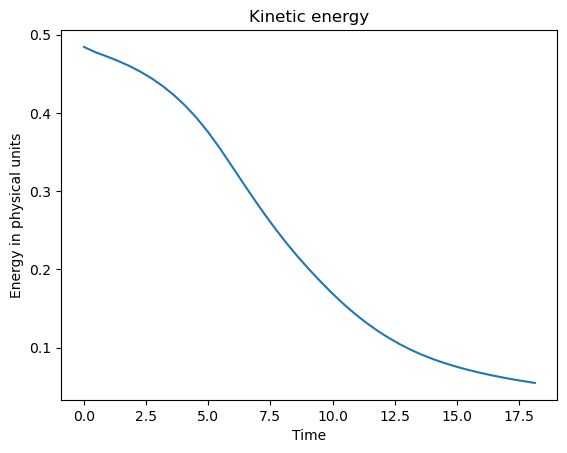

In [4]:
energy = np.array(simulation.reporter[0].out)
print(energy.shape)
plt.plot(energy[:,1],energy[:,2])
plt.title('Kinetic energy')
plt.xlabel('Time')
plt.ylabel('Energy in physical units')
plt.show()

### Velocity
We calculate the speed in Lettuce units depending on the last 'f'. Then we convert this velocity into physical units. For further investigations the tensor must be converted into a Numpy-Array. The norm of the fractions in x and y direction is plotted afterwards.

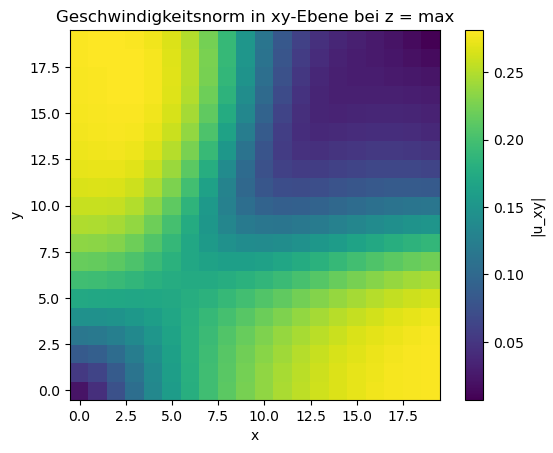

In [5]:
u = flow.u_pu.cpu().numpy()
# Slice bei z = -1
ux = u[0, :, :, -1]
uy = u[1, :, :, -1]

# Norm der xy-Geschwindigkeit (ohne uz)
u_xy_norm = np.sqrt(ux**2 + uy**2)

# Plot
plt.imshow(u_xy_norm.T, origin='lower', cmap='viridis')
plt.colorbar(label='|u_xy|')
plt.title('Geschwindigkeitsnorm in xy-Ebene bei z = max')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
